In [1]:
using Revise
import SuperconductingCavities as SC

using YAXArrays
using DimensionalData

using Logging
using MiniLoggers

import CairoMakie as cm

import FFTW

using Interpolations
using Plots

[ Info: new driver key :netcdf, updating backendlist.
┌ Info: new driver key :netcdf, updating backendlist.
└ @ NetCDFExt /home/gr400/.julia/packages/YAXArrayBase/Xj43k/ext/NetCDFExt.jl:81


In [2]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(21) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

In [3]:
Mode3 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode3/Mode3.json");

# Implimenting Digitization and Filters (Design Phase)

## Getting Base Signal

In [4]:
envelope = SC.Dynamics.Envelopes.Get_Envelope("Sine_Squared_Ramp", Dict{Any, Any}("ramp_time"  => 10, "pulse_time" => 100))

ν = Mode3.Stuff["op_drive_params"]["sb_f_0_Main"]["freq_d"]+Mode3.Stuff["op_drive_params"]["sb_f_0_Main"]["shift"]
ε = Mode3.Stuff["op_drive_params"]["sb_f_0_Main"]["epsilon"]

sig_func = SC.Dynamics.Get_Drive_Coef(ν, ε, envelope=envelope, return_ℂ=true)

(::SuperconductingCavities.Dynamics.var"#drive_coef#4"{Bool, SuperconductingCavities.Dynamics.var"#drive_coef#2#5"{SuperconductingCavities.Dynamics.Envelopes.var"#envelope#9"{String, Dict{Symbol, Any}}, Float64, SuperconductingCavities.Dynamics.var"#ϕ#3"{Float64}}}) (generic function with 1 method)

In [58]:
function DigitizeEnvelope(t, envelope; step_length = 2.3)
    N = floor(t/step_length)
    return envelope(N*step_length)
end

envelope_d(t) = DigitizeEnvelope(t, envelope)
sig_func_d = SC.Dynamics.Get_Drive_Coef(ν, ε, envelope=envelope_d)

(::SuperconductingCavities.Dynamics.var"#drive_coef#3"{Bool, SuperconductingCavities.Dynamics.var"#drive_coef#2#4"{typeof(envelope_d), Float64, Float64}}) (generic function with 1 method)

In [34]:
fs = 1e2
times = collect(0:1/fs:100)
sig = sig_func.(times);
ev = envelope.(times);
ev_d = DigitizeEnvelope.(times, envelope);
sig_d = sig_func_d.(times);

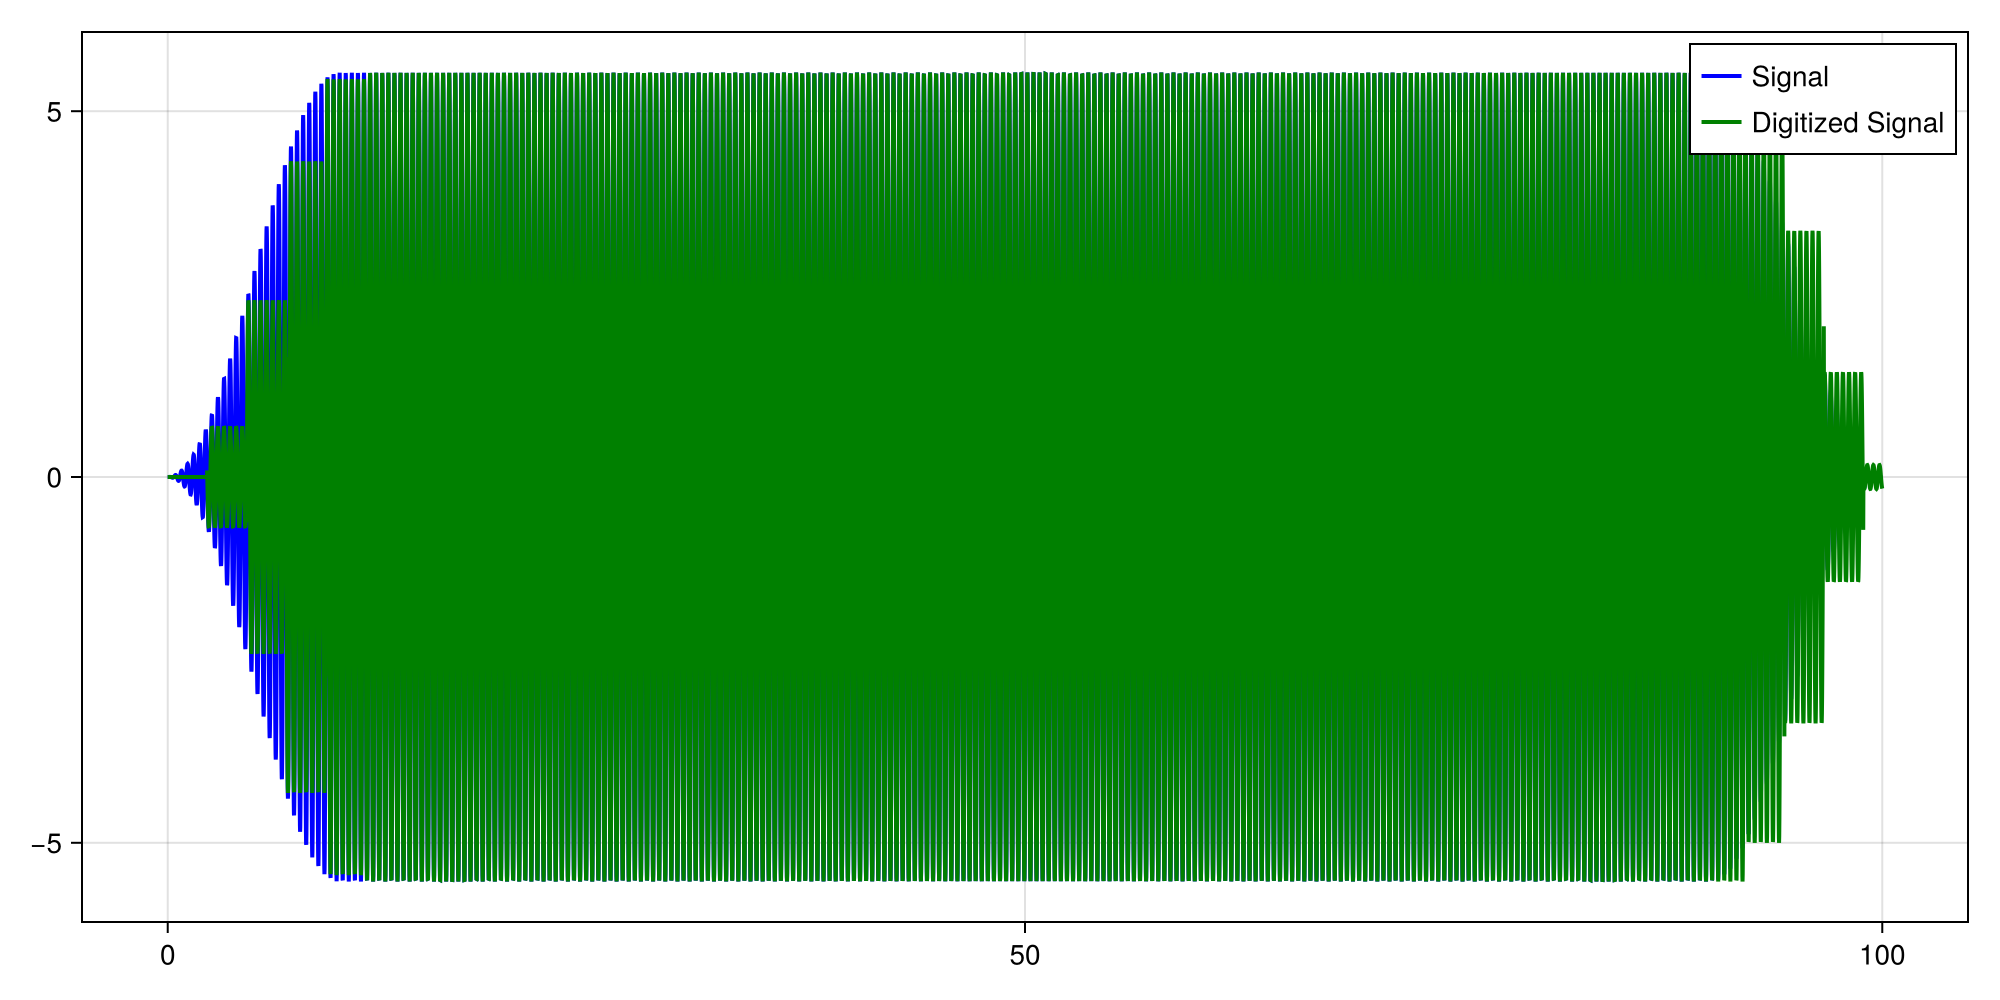

In [40]:
f = cm.Figure(size=(1000, 500))
ax = cm.Axis(f[1, 1])

plot_every = 1
x = times[1:plot_every:end]
y = imag.(sig[1:plot_every:end])
cm.lines!(ax, x, y, color=:blue,linewidth=2, label = "Signal")

x = times[1:plot_every:end]
y = imag.(sig_d[1:plot_every:end])
cm.lines!(ax, x, y, color=:green,linewidth=2, label = "Digitized Signal")
cm.axislegend(ax, position = :rt)
f

## Filtering

### Getting Fourier Transform

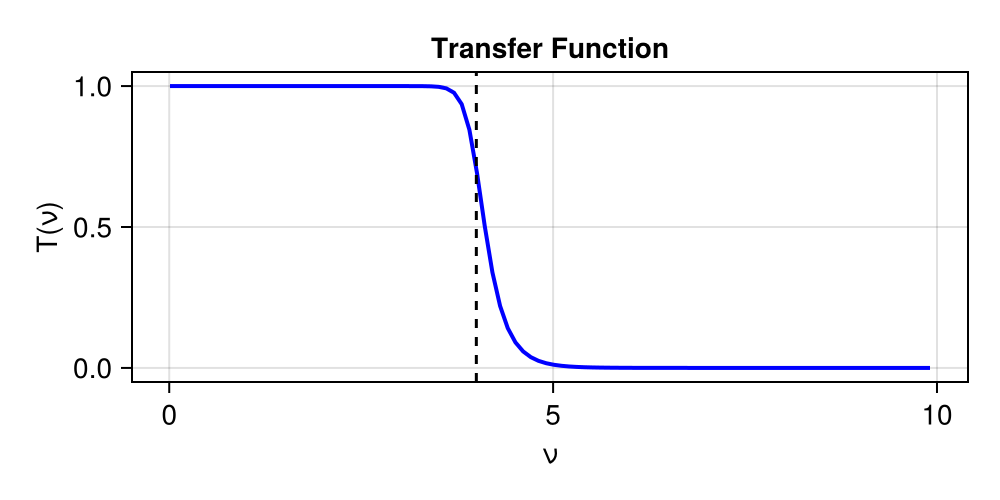

In [52]:
fft = FFTW.fft(sig);
fft_d = FFTW.fft(sig_d);

freqs = collect(1:1:length(fft))*fs/length(fft);

ν_cutoff = 4
order = 20
T(ν) = (1/(sqrt(1 + ((ν)/(ν_cutoff))^(2*order))))

Y = fft.*T.(freqs)
Y_d = fft_d.*T.(freqs)

ifft = (FFTW.ifft(Y))
ifft_d = (FFTW.ifft(Y_d)); 

f = cm.Figure(size=(500, 250))
ax = cm.Axis(f[1, 1], xlabel="ν", ylabel="T(ν)", title="Transfer Function")

plot_every = 10
plot_before = 1000# length(freqs)
x = freqs[1:plot_every:plot_before]
y = abs.(T.(freqs))[1:plot_every:plot_before]
cm.lines!(ax, x, y, color=:blue,linewidth=2, label = "Transfer Function")
cm.vlines!(ax, [ν_cutoff], color=:black, linestyle = :dash, label = "Cutoff Frequency")
f

In [46]:
T(ν_cutoff)

0.7071067811865475

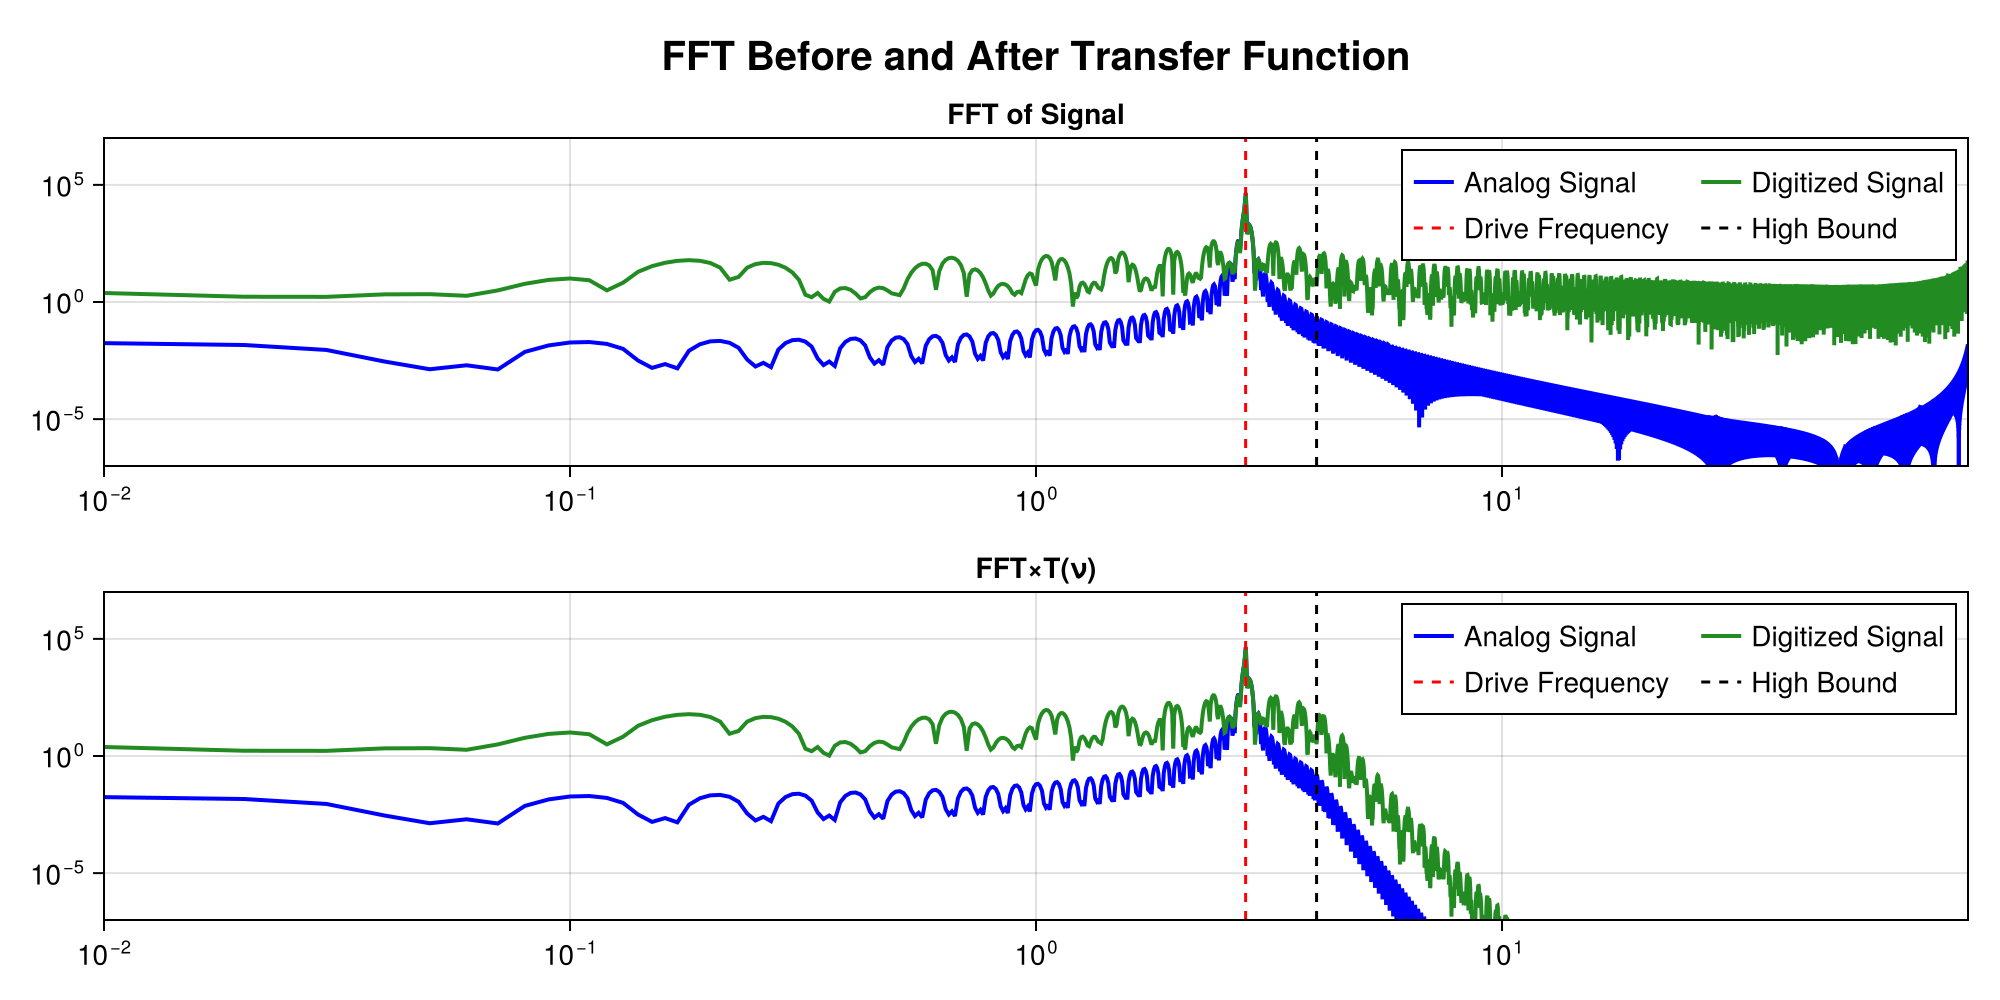

In [55]:
plot_every = 1
plot_before = length(fft)
x = collect(0:1:length(fft))[1:plot_every:plot_before]*fs/length(fft)

fig_size = (1000, 500)
lims = ((x[2], x[end]), (1e-7, 1e7))

f = cm.Figure(size=fig_size)
ax = cm.Axis(f[1, 1], xscale = cm.log10, yscale = cm.log10, limits = lims, title="FFT of Signal")

y = abs.(fft[1:plot_every:plot_before])
cm.lines!(ax, x, y, color=:blue,linewidth=2, label = "Analog Signal")


y = abs.(fft_d[1:plot_every:plot_before])
cm.lines!(ax, x, y, color=:forestgreen,linewidth=2, label = "Digitized Signal")

cm.vlines!(ax, [abs(ν)], color=:red, label = "Drive Frequency", linestyle = :dash)
#cm.vlines!(ax, [1], color = :black, label = "Low Bound", linestyle = :dash)
cm.vlines!(ax, [ν_cutoff], color = :black, label = "High Bound", linestyle = :dash)
cm.axislegend(ax, position = :rt, nbanks = 2)

ax2 = cm.Axis(f[2, 1], xscale = cm.log10, yscale = cm.log10, limits = lims, title = "FFT×T(ν)")

y = abs.(Y[1:plot_every:plot_before])
cm.lines!(ax2, x, y, color=:blue,linewidth=2, label = "Analog Signal")


y = abs.(Y_d[1:plot_every:plot_before])
cm.lines!(ax2, x, y, color=:forestgreen,linewidth=2, label = "Digitized Signal")

cm.vlines!(ax2, [abs(ν)], color=:red, label = "Drive Frequency", linestyle = :dash)
#cm.vlines!(ax2, [1], color = :black, label = "Low Bound", linestyle = :dash)
cm.vlines!(ax2, [ν_cutoff], color = :black, label = "High Bound", linestyle = :dash)
cm.axislegend(ax2, position = :rt, nbanks = 2)

cm.Label(f[1,1:1, cm.Top()], "FFT Before and After Transfer Function", valign = :bottom, padding = (0,0,30,0), font =:bold, fontsize = 20)

f

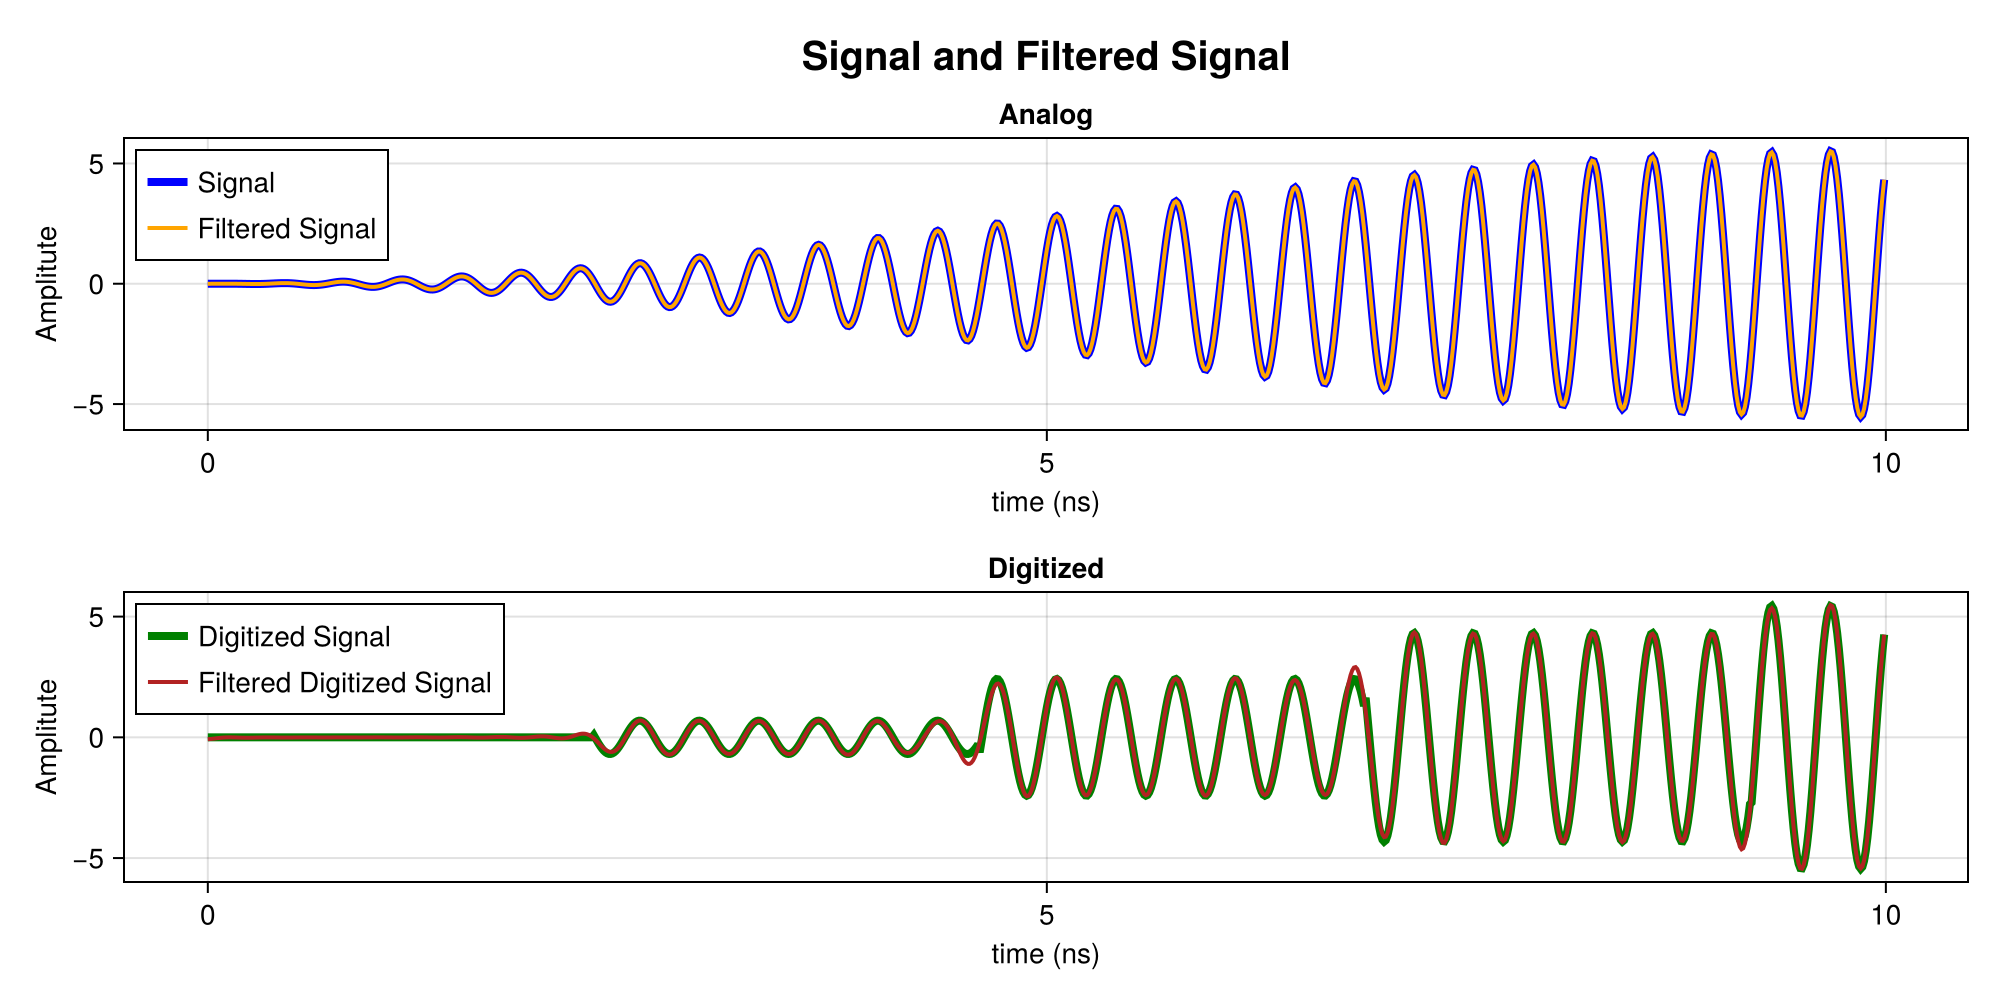

In [56]:
f = cm.Figure(size=(1000, 500))
ax = cm.Axis(f[1, 1], title="Analog", xlabel = "time (ns)", ylabel = "Amplitute")
plot_every = 1
plot_end = 1000

x = times[1:plot_every:plot_end]
y = imag.(sig[1:plot_every:plot_end])
cm.lines!(ax, x, y, color=:blue,linewidth=4, label = "Signal")

x = times[1:plot_every:plot_end]
y = imag.(ifft[1:plot_every:plot_end])
cm.lines!(ax, x, y, color=:orange,linewidth=2, label = "Filtered Signal")

cm.axislegend(ax, position = :lt)

ax2 = cm.Axis(f[2, 1], title = "Digitized", xlabel = "time (ns)", ylabel = "Amplitute")

x = times[1:plot_every:plot_end]
y = imag.(sig_d[1:plot_every:plot_end])
cm.lines!(ax2, x, y, color=:green,linewidth=4, label = "Digitized Signal")

x = times[1:plot_every:plot_end]
y = imag.(ifft_d[1:plot_every:plot_end])
cm.lines!(ax2, x, y, color=:firebrick,linewidth=2, label = "Filtered Digitized Signal")

cm.axislegend(ax2, position = :lt)

cm.Label(f[1,1:1, cm.Top()], "Signal and Filtered Signal", valign = :bottom, padding = (0,0,30,0), font =:bold, fontsize = 20)
f

In [22]:
#new_drive = linear_interpolation(times, ifft)

In [73]:
res = SC.Dynamics.Get_Low_Pass_Filtered_Drive_Coef(sig_func_d, 100);

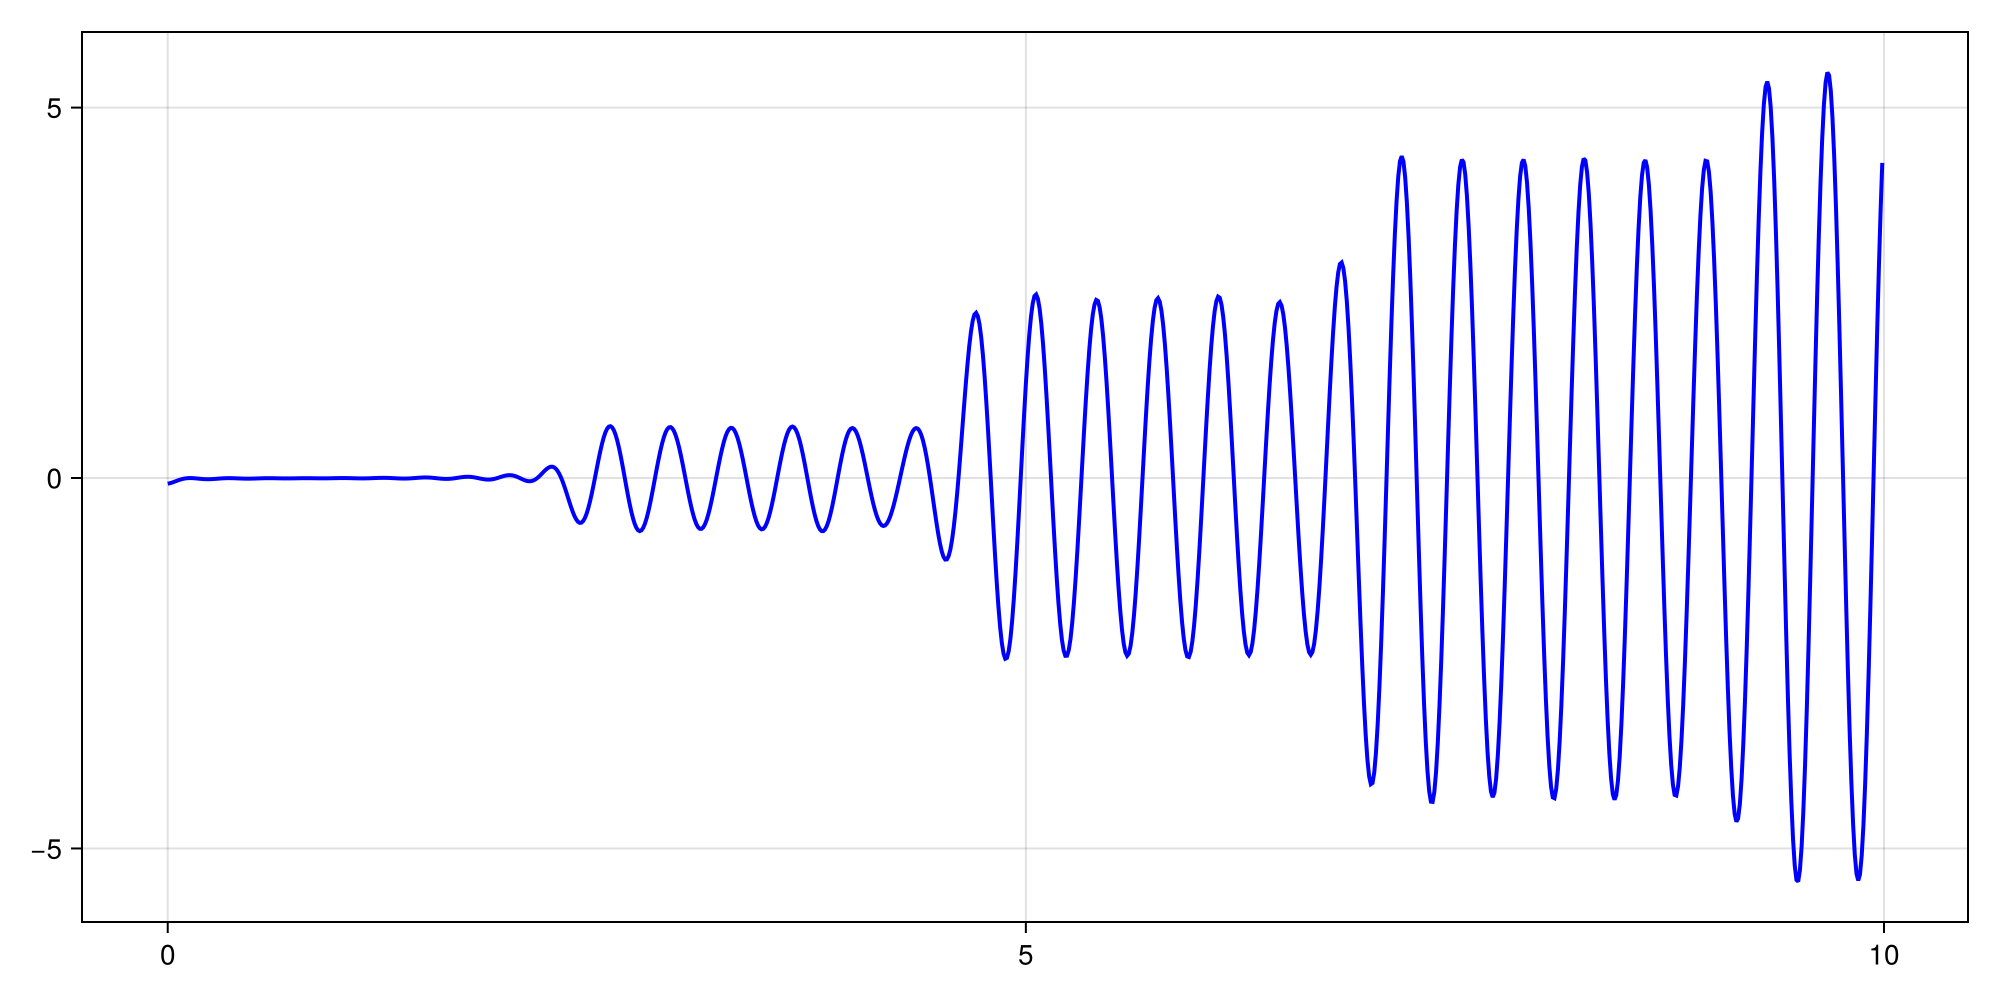

In [74]:
f = cm.Figure(size=(1000, 500))
ax = cm.Axis(f[1,1])

x = times[1:1000]
y = res.(x)

cm.lines!(ax, x, y, color=:blue,linewidth=2, label = "Filtered Signal")
f

# Testing the package

Lets digitize the f0g1 sideband and filter!

In [5]:
pulse = copy(Mode3.Stuff["op_drive_params"]["sb_f_0_Main"])

Dict{String, Any} with 6 entries:
  "pulse_time"    => 177.8
  "Envelope Args" => Dict{String, Any}("pulse_time"=>177.8, "ramp_time"=>10)
  "epsilon"       => 0.88
  "Envelope"      => "Sine_Squared_Ramp"
  "shift"         => 0.0530359
  "freq_d"        => -2.87015

In [6]:
ε = pulse["epsilon"]
ν = pulse["freq_d"] + pulse["shift"]

envelope = SC.Dynamics.Envelopes.Get_Envelope(pulse["Envelope"], pulse["Envelope Args"], digitize = true)


base_drive_coef = SC.Dynamics.Get_Drive_Coef(ν, ε, envelope=envelope);

drive_coef = SC.Dynamics.Get_Low_Pass_Filtered_Drive_Coef(base_drive_coef, pulse["pulse_time"], poles = 20, freq_cutoff = 3.2, fs = 1e2);

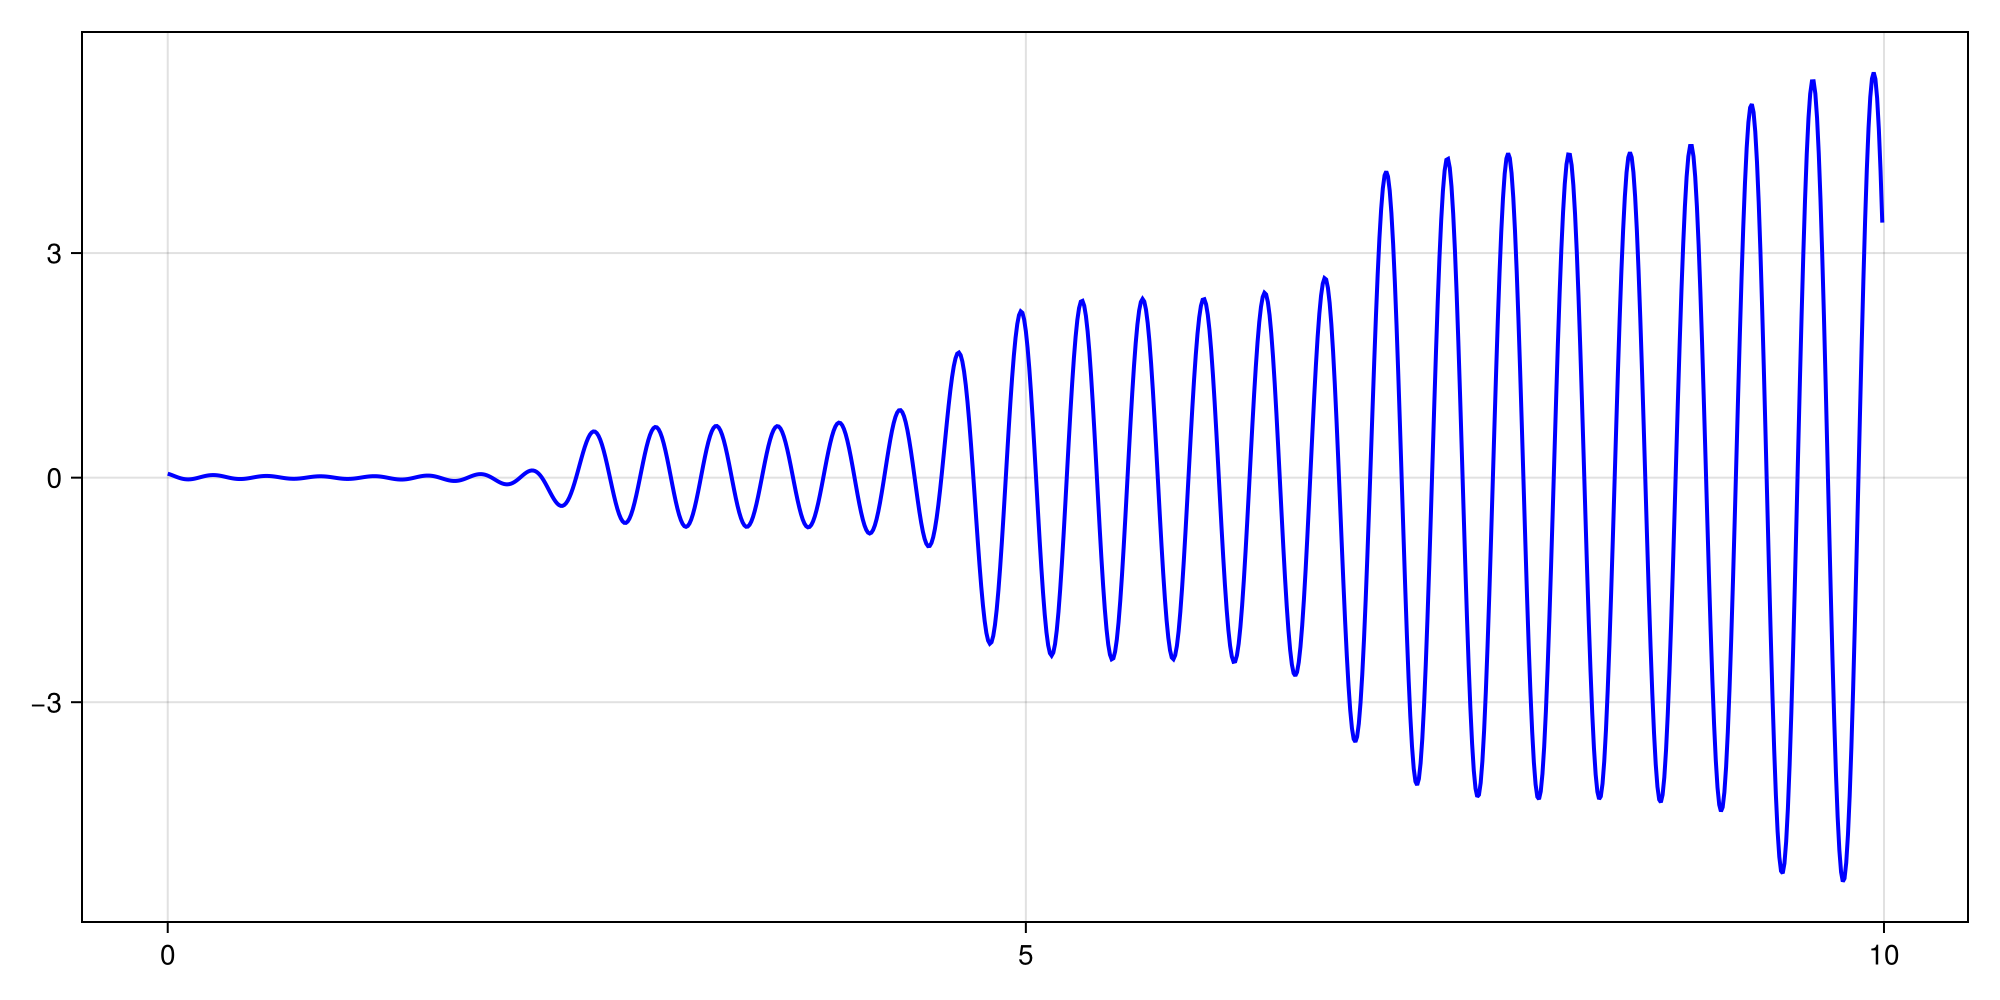

In [7]:
x = collect(0:1e-2:pulse["pulse_time"])[1:1000]
y = drive_coef.(x)

f = cm.Figure(size=(1000, 500))
ax = cm.Axis(f[1,1])
cm.lines!(ax, x, y, color=:blue,linewidth=2, label = "Filtered Signal")
f

## Calibrating a pulse

In [8]:
ψ1 = Mode3.dressed_states[(2,0)]
ψ2 = Mode3.dressed_states[(0,1)]

#ε = 0.78
freq_d = Mode3.Stuff["op_drive_params"]["sb_f_0_Main"]["freq_d"]
shift = Mode3.Stuff["op_drive_params"]["sb_f_0_Main"]["shift"]
ε = Mode3.Stuff["op_drive_params"]["sb_f_0_Main"]["epsilon"]
#shift = 0.042200385158

rt = 10
t_range = [160, 190]
envelope = "Sine_Squared_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" => rt)
filter_params = Dict{Any, Any}("poles" => 20)

res = SC.Dynamics.OptimizePulse(Mode3, ψ1, ψ2, ε, freq_d, shift, t_range, envelope, envelope_args, samples_per_level = 5, digitize = true, step_length = 2.3, filter_params = filter_params)

[2024-11-04 15:31:24] Info: On Level 1
[2024-11-04 15:31:24] Info: On Step 1: t = 160.0
[2024-11-04 15:31:25] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-04 15:31:31] Info: Time Evolution Complete
[2024-11-04 15:31:31] Info: Done with Level_1_step_1
[2024-11-04 15:31:31] Info: Accurace: 0.9578124817264378
[2024-11-04 15:31:31] Info: ------------------------------------------------------------------------------
[2024-11-04 15:31:31] Info: On Step 2: t = 167.5
[2024-11-04 15:31:31] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-04 15:31:34] Info: Time Evolution Complete
[2024-11-04 15:31:34] Info: Done with Level_1_step_2
[2024-11-04 15:31:34] Info: Accurace: 0.9743660328119335
[2024-11-04 15:31:34] Info: ------------------------------------------------------------------------------
[2024-11-04 15:31:34] Info: O

Dict{Any, Any} with 10 entries:
  "pulse_time"    => 180.625
  "digitize"      => true
  "freq_d"        => -2.87015
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>180.625, "ramp_time"=>10)
  "epsilon"       => 0.88
  "filter_params" => Dict{Any, Any}("poles"=>20)
  "Envelope"      => "Sine_Squared_Ramp"
  "shift"         => 0.0530359
  "accuracy"      => 0.983024
  "step_length"   => 2.3

In [9]:
Mode3.Stuff["op_drive_params"]["sb_f_0_Main"]

Dict{String, Any} with 6 entries:
  "pulse_time"    => 177.8
  "Envelope Args" => Dict{String, Any}("pulse_time"=>177.8, "ramp_time"=>10)
  "epsilon"       => 0.88
  "Envelope"      => "Sine_Squared_Ramp"
  "shift"         => 0.0530359
  "freq_d"        => -2.87015

In [4]:
#pulse = copy(res)
pulse = copy(Mode3.Stuff["op_drive_params"]["sb_f_0_Main"])

#pulse["digitize"] = true
#pulse["step_length"] = 2.3
ψ = Mode3.dressed_states[(2,0)]

stroboscopic_times = SC.Dynamics.Get_Stroboscopic_Times(pulse)

run_res = SC.Dynamics.RunSingleOperator(Mode3, ψ, pulse, to_return = "All", tspan = stroboscopic_times, return_drive_coef = true)

pulse["filter_params"] = Dict{Any, Any}("poles" => 10, "re_or_im" => real)
stroboscopic_times2 = SC.Dynamics.Get_Stroboscopic_Times(pulse, start_at = 2)

run_res2 = SC.Dynamics.RunSingleOperator(Mode3, ψ, pulse, to_return = "All", tspan = stroboscopic_times, return_drive_coef = true)

#13 (generic function with 1 method)

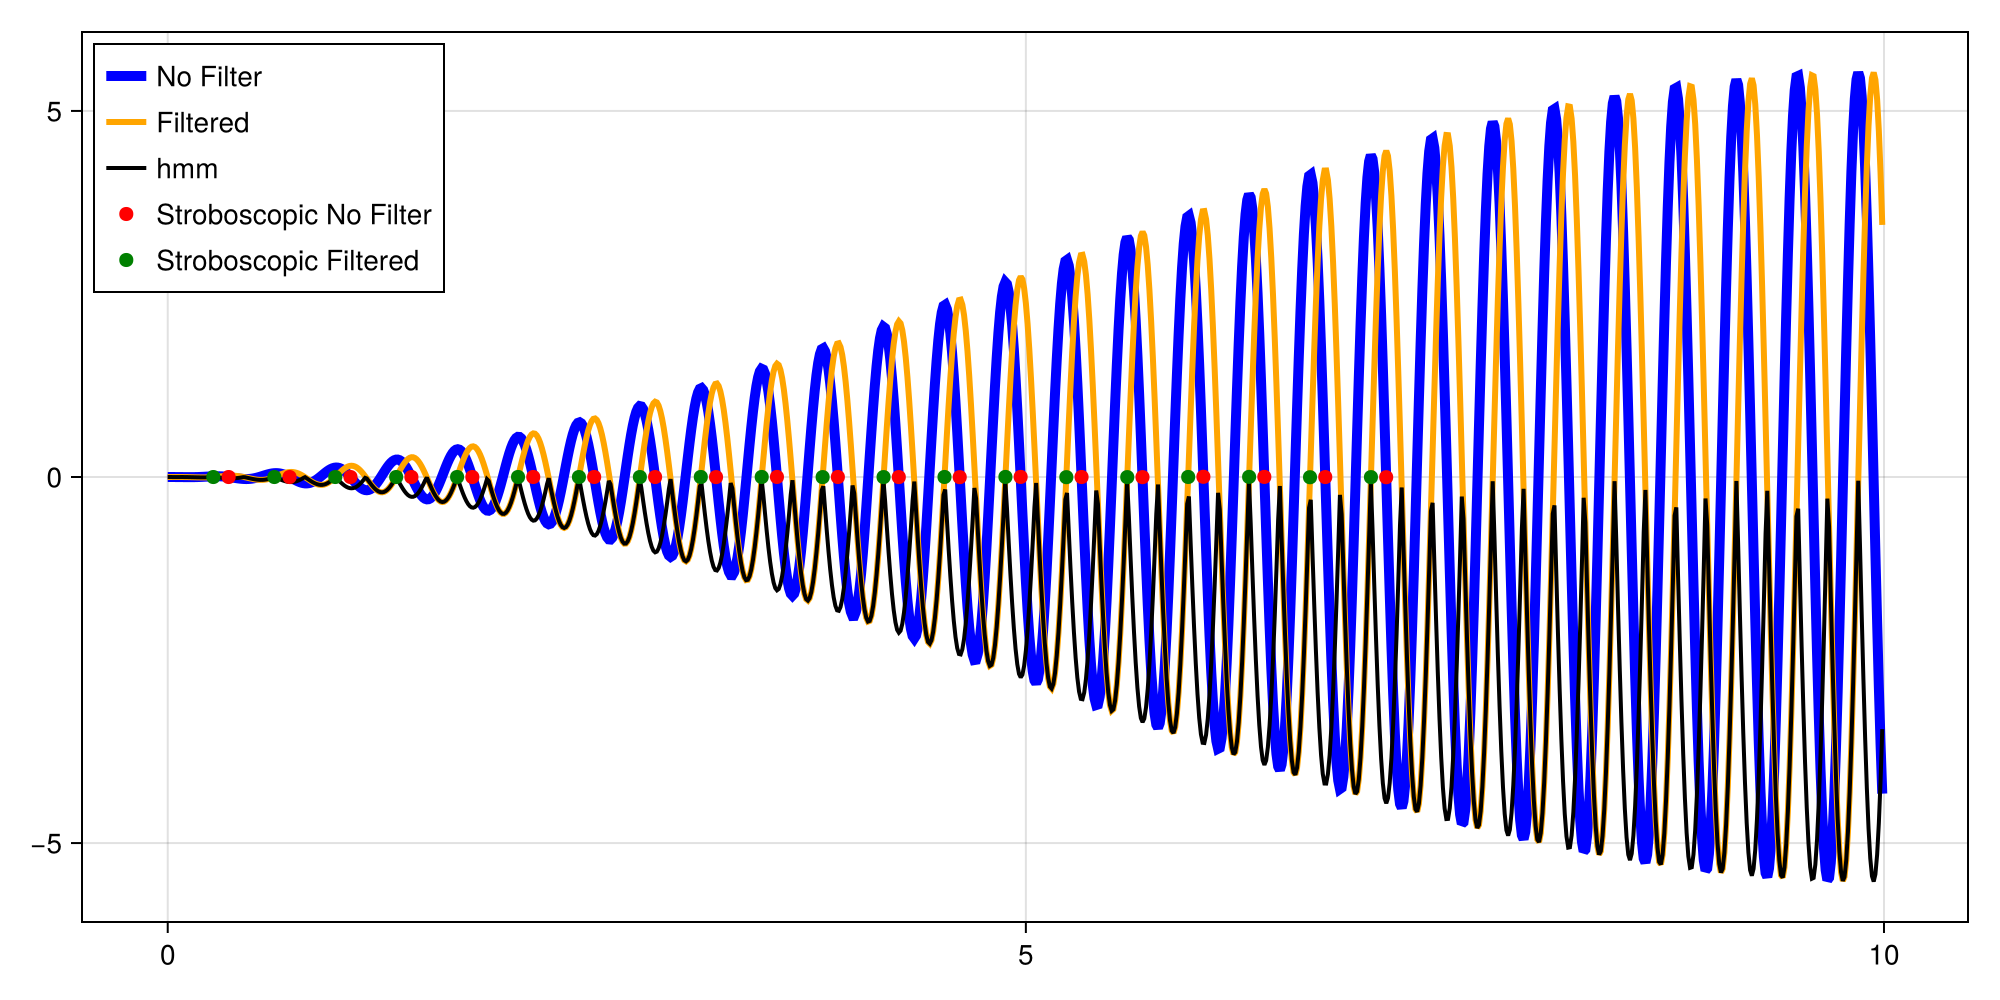

In [11]:
times = collect(0:0.01:pulse["pulse_time"])[1:1000]

f = cm.Figure(size=(1000, 500))
ax = cm.Axis(f[1,1])

cm.lines!(ax, times, run_res.(times), color=:blue, linewidth=5, label = "No Filter")
cm.lines!(ax, times, run_res2.(times), color=:orange, linewidth=3, label = "Filtered")


cm.lines!(ax, times, -abs.(run_res2.(times)), color=:black, linewidth=2, label = "hmm")
x = stroboscopic_times[1:20]
cm.scatter!(ax, x, run_res.(x), color=:red, markersize = 10, label = "Stroboscopic No Filter")

x = stroboscopic_times2[1:20]
cm.scatter!(ax, x, run_res2.(x), color=:green, markersize = 10, label = "Stroboscopic Filtered")

cm.axislegend(ax, position = :lt)

f

In [12]:
pulse = copy(res)
pulse = copy(Mode3.Stuff["op_drive_params"]["sb_f_0_Main"])

#pulse["digitize"] = true
#pulse["step_length"] = 2.3

pulse["filter_params"] = Dict{Any, Any}("poles" => 10, "re_or_im" => real)


ψ = Mode3.dressed_states[(2,0)]

stroboscopic_times = SC.Dynamics.Get_Stroboscopic_Times(pulse, sample_every = 10, start_at = 2)

run_res = SC.Dynamics.RunSingleOperator(Mode3, ψ, pulse, to_return = "All", tspan = stroboscopic_times)

[2024-11-04 15:33:04] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-04 15:33:06] Info: Time Evolution Complete
[2024-11-04 15:33:06] Info: Done with DEFAULT


Solution of time evolution
(return code: Success)
--------------------------
num_states = 52
num_expect = 0
ODE alg.: OrdinaryDiffEqVerner.Vern9{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, static(false), true)
abstol = 1.0e-6
reltol = 1.0e-6


In [13]:
floq_sweep = SC.Dynamics.Get_Pulse_Floquet_Sweep(Mode3.hilbertspace, Mode3.n̂ₜ, pulse; stroboscopic_times = stroboscopic_times);

Filtering: true
[2024-11-04 15:33:16] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[2024-11-04 15:34:03] Info: Done With Floquet Sweep
[2024-11-04 15:34:03] Info: Tracking State


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[2024-11-04 15:34:03] Info: Running the necessary time evolutions


In [14]:
floq_proj = SC.Dynamics.Pulse_Floquet_Projections(run_res, floq_sweep);

[2024-11-04 15:34:04] Info: Making Plot


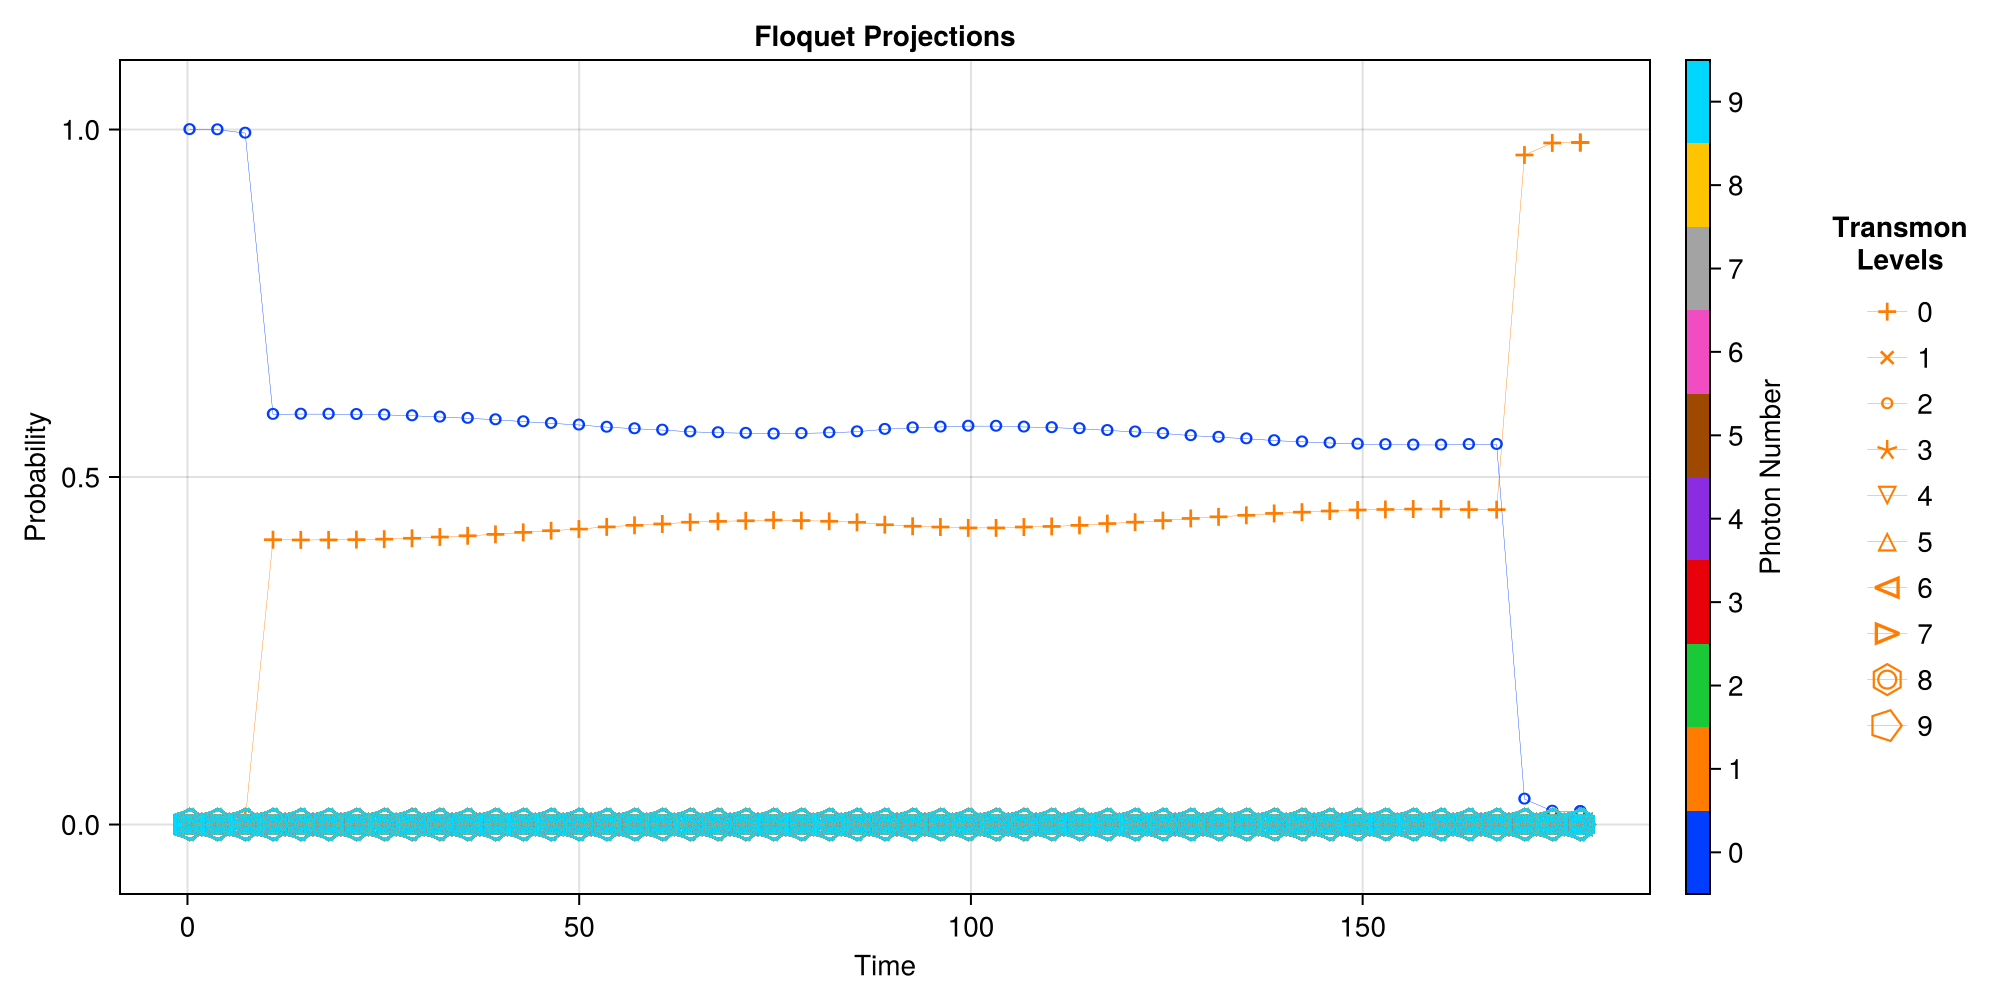

CairoMakie.Screen{IMAGE}


In [15]:
axis_kwargs = Dict{Any, Any}("title" => "Floquet Projections")
SC.Dynamics.PlotSingleModeEvolution(Mode3, run_res.times, floq_proj, axis_kwargs = axis_kwargs)

In [16]:
proj_ops = SC.Utils.Get_Projection_Ops(Mode3.dressed_states);
EVs = SC.Utils.Get_EVs(run_res.states, proj_ops);

[2024-11-04 15:34:08] Info: Making Plot


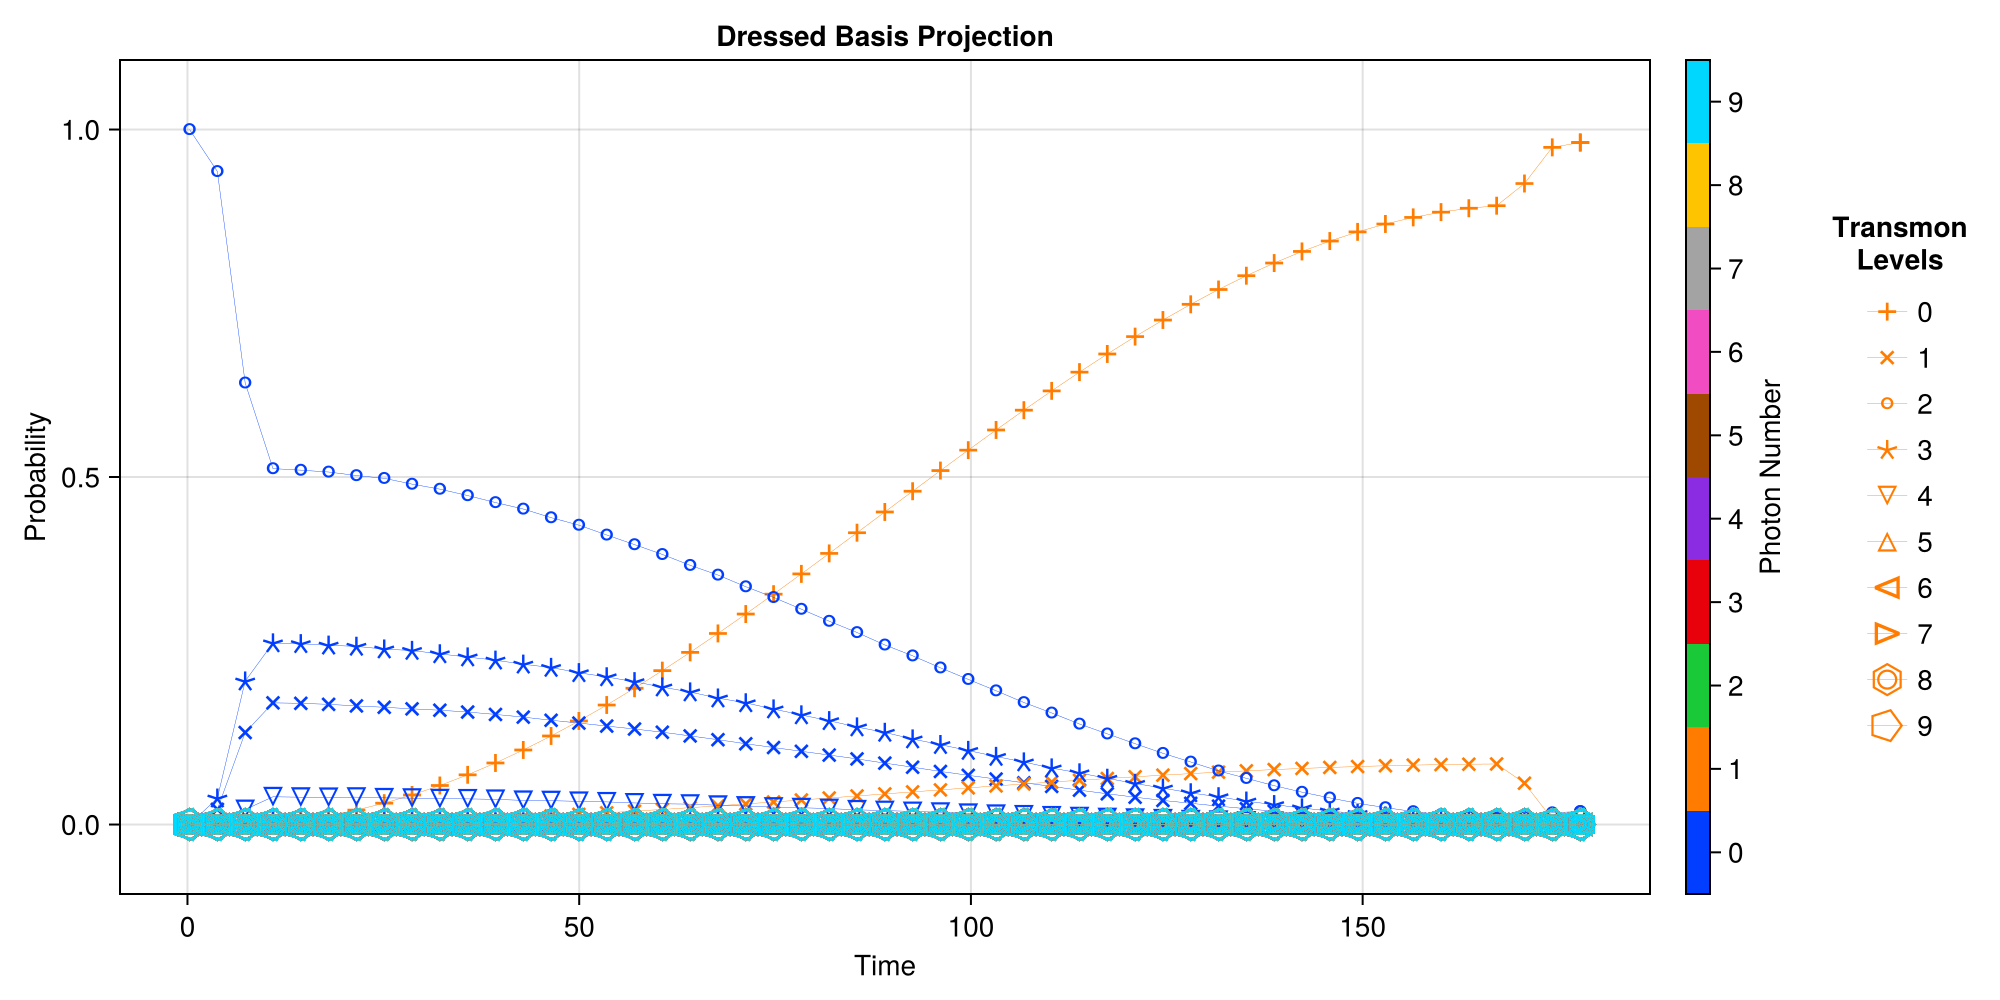

CairoMakie.Screen{IMAGE}


In [17]:
axis_kwargs = Dict{Any, Any}("title" => "Dressed Basis Projection")
SC.Dynamics.PlotSingleModeEvolution(Mode3, run_res.times, EVs, axis_kwargs = axis_kwargs)

In [545]:
abs(run_res.states[end]'*Mode3.dressed_states[(0,1)])^2

0.9813199292595208